Instructions for installing `rubin_sim` can be found at:  https://github.com/lsst/rubin_sim

In [1]:
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.surveys import BaseSurvey
from rubin_scheduler.scheduler.utils import ObservationArray
from rubin_scheduler.scheduler.schedulers import CoreScheduler, SimpleBandSched
from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.detailers import BaseDetailer
from rubin_scheduler.utils import _approx_ra_dec2_alt_az, _approx_altaz2pa, rotation_converter

import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd

Some things to note about the `rubin_scheduler.scheduler` package:

* Rubin observatory should make 800-1,000 observations in a night. That's too many to schedule manually. The goal of the scheduler package is to generate those observations
* Because there can be weather interuptions, the scheduler needs to be able to make fast real-time decisions.
* This means the scheduler is not solving an optimization problem. Rather, the goal of the scheduler is to be an artificial intelligence that can answer the question, "given the current progress and conditions, what is a good observation to make?"



In [2]:
# load up a model observatory.
nside=32  # Specify the HEALpix resolution we want to do everything in.
mjd_start = 60218
mo = ModelObservatory(nside=nside, mjd_start=mjd_start, downtimes="ideal")

In [3]:
conditions = mo.return_conditions()

In [4]:
conditions

Conditions at 0x1453116d0
============================
nside:  32   
site:  LSST   
exptime:  30.0   
lmst:  19.914909990207565   
clouds:  None   
current_band:  r   
mounted_bands:  ['u', 'g', 'r', 'i', 'y']   
night:  0   
wind_speed:  None   
wind_direction:  None   
len(scheduled_observations):  0   
len(queue):  None   
moonPhase:  87.4203758755475   
bulk_cloud:  0.25   
targets_of_opportunity:  None   
cumulative_azimuth_rad:  0   

Positions (radians)
-------------------
| name      |         alt |        az |         RA |        decl |   rot |
|:----------|------------:|----------:|-----------:|------------:|------:|
| sun       |  -0.298117  |   4.46742 |   3.25752  |  -0.0500932 |   nan |
| moon      |  -0.0933059 |   1.3813  |   0.481501 |   0.208454  |   nan |
| venus     | nan         | nan       |   0.627558 |   0.209499  |   nan |
| mars      | nan         | nan       |   3.6558   |  -0.199382  |   nan |
| jupiter   | nan         | nan       |   0.615007 |   0.223621  |   nan |
| saturn    | nan         | nan       |   5.8825   |  -0.198137  |   nan |
| telescope |   1.50971   |   0       | nan        | nan         |     0 |

Positions (degrees)
-------------------
| name      |       alt |       az |       RA |      decl |   rot |
|:----------|----------:|---------:|---------:|----------:|------:|
| sun       | -17.0808  | 255.965  | 186.642  |  -2.87013 |   nan |
| moon      |  -5.34603 |  79.1424 |  27.588  |  11.9435  |   nan |
| venus     | nan       | nan      |  35.9564 |  12.0034  |   nan |
| mars      | nan       | nan      | 209.462  | -11.4237  |   nan |
| jupiter   | nan       | nan      |  35.2373 |  12.8126  |   nan |
| saturn    | nan       | nan      | 337.042  | -11.3524  |   nan |
| telescope |  86.5     |   0      | nan      | nan       |     0 |

Events
------
| event           |     MJD | date                          |
|:----------------|--------:|:------------------------------|
| sunset          | 60217.9 | 2023-09-30 22:39:51.396550833 |
| sun_n12_setting | 60218   | 2023-09-30 23:35:54.323995110 |
| mjd             | 60218   | 2023-10-01 00:00:00           |
| sun_n18_setting | 60218   | 2023-10-01 00:04:24.044514294 |
| moonrise        | 60218   | 2023-10-01 00:26:34.205152992 |
| sun_n18_rising  | 60218.4 | 2023-10-01 09:00:52.960203587 |
| sun_n12_rising  | 60218.4 | 2023-10-01 09:29:21.607463656 |
| sunrise         | 60218.4 | 2023-10-01 10:25:21.735043824 |
| moonset         | 60218.5 | 2023-10-01 11:37:30.832423564 |

Maps
----
| map             |   nside |       min |        max |    median |
|:----------------|--------:|----------:|-----------:|----------:|
| ra              |      32 |  0        |    6.25864 |  3.12932  |
| airmass         |      32 |  1.00008  | 7563.71    |  1.99823  |
| dec             |      32 | -1.54528  |    1.54528 |  0        |
| slewtime        |      32 |  5.25048  |  155.977   | 94.9251   |
| fwhm_eff_u      |      32 |  0.810881 |    3.50529 |  1.1675   |
| fwhm_eff_g      |      32 |  0.771036 |    3.33305 |  1.11013  |
| fwhm_eff_r      |      32 |  0.734788 |    3.17635 |  1.05794  |
| fwhm_eff_i      |      32 |  0.709899 |    3.06876 |  1.02211  |
| fwhm_eff_z      |      32 |  0.693443 |    2.99763 |  0.998413 |
| fwhm_eff_y      |      32 |  0.680305 |    2.94083 |  0.979497 |
| m5_depth_u      |      32 | 22.2502   |   23.7238  | 23.2556   |
| m5_depth_g      |      32 | 23.5166   |   25.0076  | 24.6241   |
| m5_depth_r      |      32 | 23.2615   |   24.6308  | 24.252    |
| m5_depth_i      |      32 | 22.9295   |   24.1963  | 23.7959   |
| m5_depth_z      |      32 | 22.4528   |   23.6088  | 23.1961   |
| m5_depth_y      |      32 | 21.4032   |   22.6591  | 22.1965   |
| skybrightness_u |      32 | 21.6156   |   22.5797  | 22.3855   |
| skybrightness_g |      32 | 20.6308   |   22.1424  | 21.9003   |
| skybrightness_r |      32 | 19.8154   |   21.2297  | 20.964    |
| skybrightness_i |      32 | 19.1394   |   20.3616  | 20.0661   |
| skybrightness_z |      32 | 18.4153   |   19.4577  | 19.1355   |
| skybrightness_y |      32 | 17.6507   |   18.5773  | 18.2473   |


In [5]:
# The conditions object has lots of attributes with information about the state of the telescope. 
print('mjd= %f, moonPhase=%f, night=%i' % (conditions.mjd, conditions.moon_phase, conditions.night))

mjd= 60218.000000, moonPhase=87.420376, night=0


In [6]:
# Print the currently mounted bands
conditions.mounted_bands

['u', 'g', 'r', 'i', 'y']

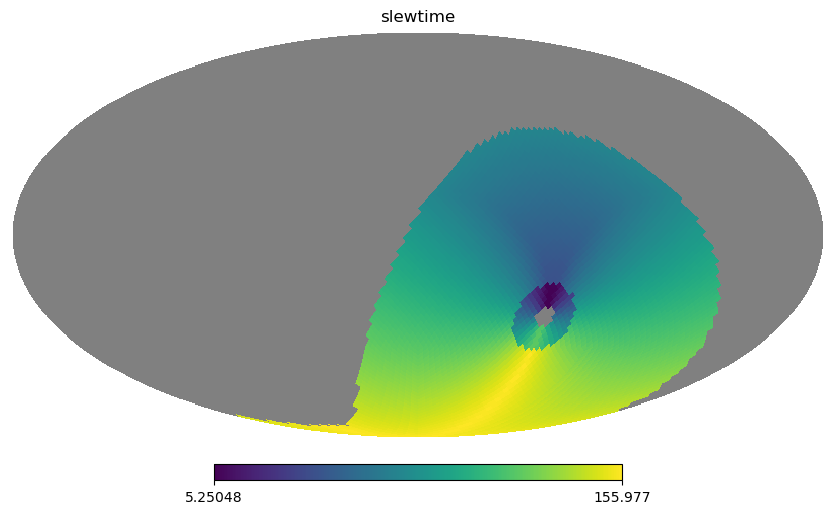

In [7]:
# Some values in the conditions object are stored as HEALpix arrays
hp.mollview(conditions.slewtime, title='slewtime')

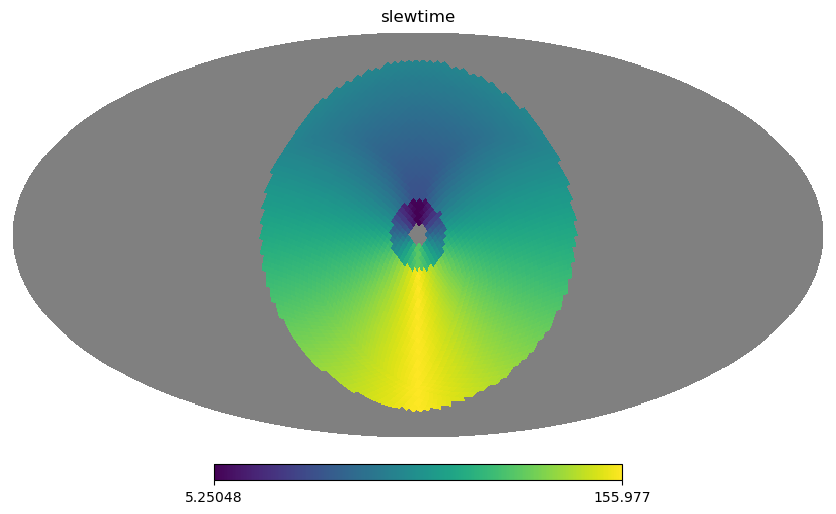

In [8]:
# All the HEALpix maps are stored as RA,dec. We can use the info in the conditions 
# object to rotate to alt,az (so zenith is at the center, north is up, hopefully east is left)
hp.mollview(conditions.slewtime, title='slewtime', rot=((conditions.lmst*180/12), conditions.site.latitude))

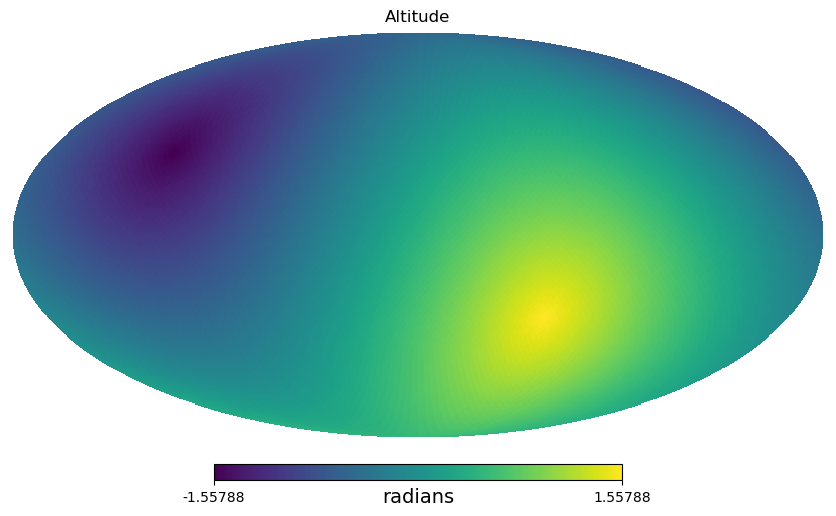

In [9]:
# Internal values are stored as radians, so here's the map of altitude, in radians
hp.mollview(conditions.alt, title='Altitude', unit='radians')

In [10]:
# The latitude of the site, in radians
conditions.site.latitude_rad

-0.527864360290173

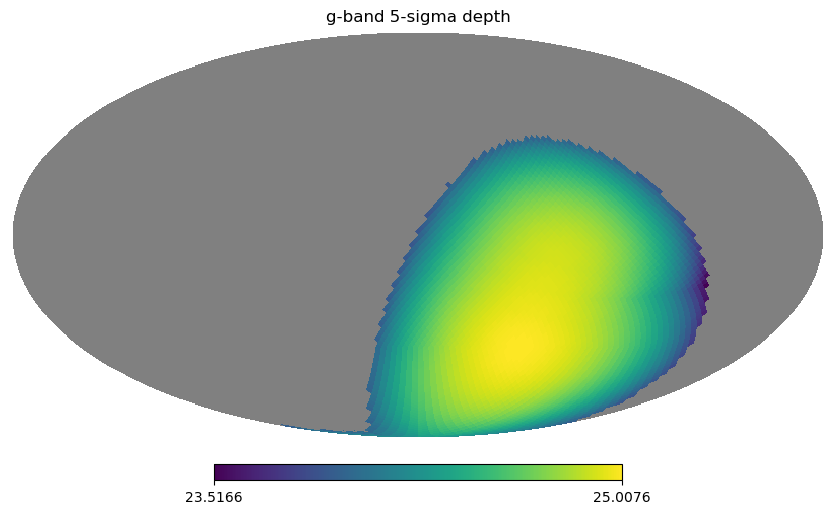

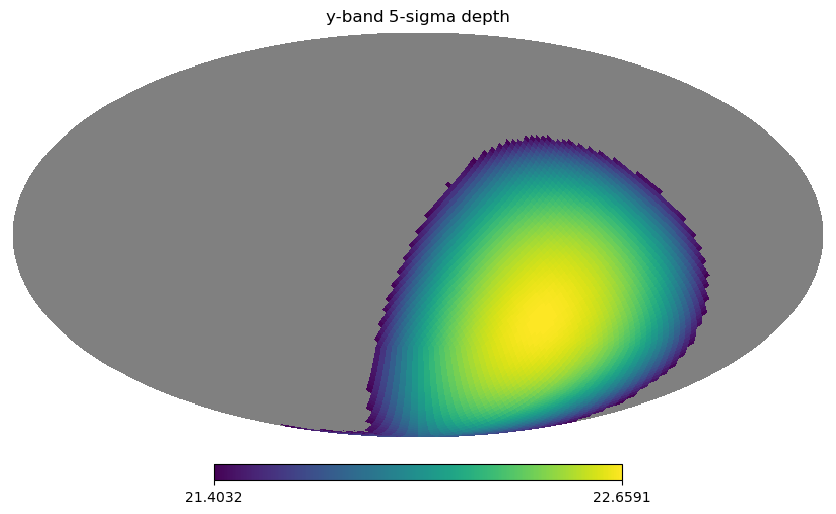

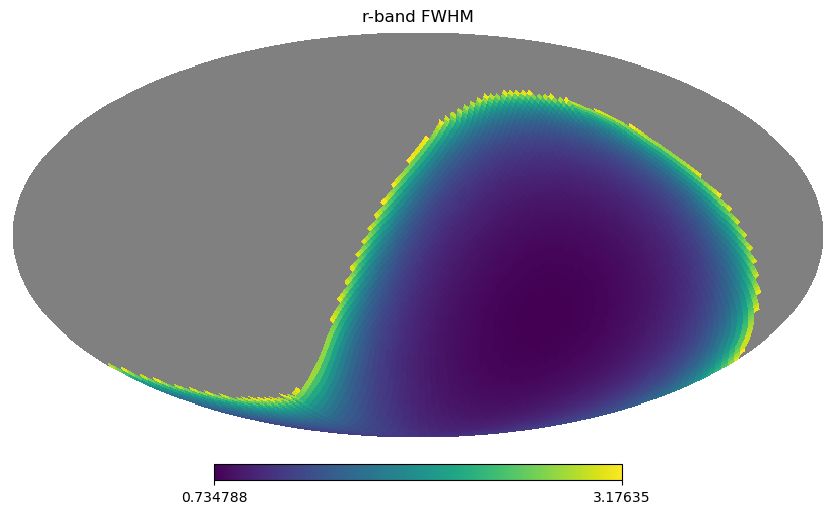

In [11]:
# If something is band-specific, we usually store it in a dict with bandname keys
hp.mollview(conditions.m5_depth['g'], title='g-band 5-sigma depth')
hp.mollview(conditions.m5_depth['y'], title='y-band 5-sigma depth')
hp.mollview(conditions.fwhm_eff['r'], title='r-band FWHM')


In [12]:
# All the things you can find in the condtions object should be in the doc string
help(conditions)

Help on Conditions in module rubin_scheduler.scheduler.features.conditions object:

class Conditions(builtins.object)
 |  Conditions(nside=32, site='LSST', exptime=30.0, mjd=None)
 |  
 |  Holds telemetry information, keeping calculated values in sync
 |  for `self.mjd` (such as ra/dec mappings to alt/az).
 |  
 |  Incoming values have setters to keep values in sync. Healpix maps
 |  are set to the expected (`self.nside`) resolution.
 |  
 |  Unless otherwise noted, all values are assumed to be valid at the time
 |  given by `self.mjd`.
 |  
 |  Parameters
 |  ----------
 |  nside : `int`, optional
 |      The healpixel nside to set the resolution of attributes.
 |      Default of None will use
 |      `rubin_scheduler.scheduler.utils.set_default_nside`.
 |  site : str ('LSST')
 |      A site name used to create a sims.utils.Site object. For
 |      looking up observatory parameters like latitude and longitude.
 |  exptime : `float`, optional
 |      The exposure time (seconds) to assu

## Observation objects ##

We have 2 types of observation objects--`ObservationArray` and `ScheduledObservationArray`. As one might expect, an `ObservationArray` is something(s) to be done immediatly, while a `ScheduledObservationArray` is an observation(s) to be done at a later time. 

A regular observation object is a numpy structured array that holds information about an observation. `Survey` objects are expected to return a list of `ObservationArray` objects. Most of the values can be ignored (the observatory will fill them in with the actual values when the observation executes). 


In [13]:
# Generate an empty observation.
obs = ObservationArray()

In [14]:
# Indeed, it is a numpy array
obs

ObservationArray([(0, 0., 0., 0., 0., 0., '', '', 0., 0., 0, 0., 0., 0., 0., 0., 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., '', '', 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., '', '')],
                 dtype=[('ID', '<i8'), ('RA', '<f8'), ('dec', '<f8'), ('mjd', '<f8'), ('flush_by_mjd', '<f8'), ('exptime', '<f8'), ('band', '<U40'), ('filter', '<U40'), ('rotSkyPos', '<f8'), ('rotSkyPos_desired', '<f8'), ('nexp', '<i8'), ('airmass', '<f8'), ('FWHM_500', '<f8'), ('FWHMeff', '<f8'), ('FWHM_geometric', '<f8'), ('skybrightness', '<f8'), ('night', '<i8'), ('slewtime', '<f8'), ('visittime', '<f8'), ('slewdist', '<f8'), ('fivesigmadepth', '<f8'), ('alt', '<f8'), ('az', '<f8'), ('pa', '<f8'), ('pseudo_pa', '<f8'), ('clouds', '<f8'), ('moonAlt', '<f8'), ('sunAlt', '<f8'), ('scheduler_note', '<U40'), ('target_name', '<U40'), ('target_id', '<i8'), ('lmst', '<f8'), ('rotTelPos', '<f8'), ('rotTelPos_backup', '<f8'), ('moonAz', '<f8'), ('sunAz', '<f8'), ('sunRA', '<f8'), ('sunDec', '<f

In [15]:
# Here's a doc string that should have all the info on the obsevation columns and their units.
help(ObservationArray)

Help on class ObservationArray in module rubin_scheduler.scheduler.utils.observation_array:

class ObservationArray(numpy.ndarray)
 |  ObservationArray(n=1)
 |  
 |  Class to work as an array of observations
 |  
 |  Parameters
 |  ----------
 |  n : `int`
 |      Size of array to return. Default 1.
 |  
 |  The numpy fields have the following labels.
 |  
 |  RA : `float`
 |     The Right Acension of the observation (center of the field)
 |     (Radians)
 |  dec : `float`
 |     Declination of the observation (Radians)
 |  mjd : `float`
 |     Modified Julian Date at the start of the observation
 |     (time shutter opens)
 |  exptime : `float`
 |     Total exposure time of the visit (seconds)
 |  band : `str`
 |      The band used. Should be one of u, g, r, i, z, y.
 |  rotSkyPos : `float`
 |      The rotation angle of the camera relative to the sky E of N
 |      (Radians). Will be ignored if rotTelPos is finite.
 |      If rotSkyPos is set to NaN, rotSkyPos_desired is used.
 |  rot

## Survey Objects ##

Survey objects generate lists of `observations`. As you might guess, they take `conditions` objects as input. They also take completed observations as input. It's up to each survey object to log any relevant survey progress independently.

Let's make a survey object that generates a list of 3 observations near the south celestial pole every time it's called, no matter what the conditions are or what has already been observed.

In [16]:
class ScpSurvey(BaseSurvey):
    """A South Celestial Pole survey"""
    # Here we are overriding generate_observations_rough. The default generate_observations method
    # calls generate_observations_rough first, then applies any detailers that were passed in on 
    # init. 
    def generate_observations_rough(self, conditions):
        obs = ObservationArray()
        obs['RA'] = 0.
        obs['dec'] = np.radians(-87.)
        obs['exptime'] = 30.  # Seconds
        obs['nexp'] = 2
        obs['band'] = 'r'
        # If it's been 12 hours or more, don't try to execute the observation anymore
        obs['flush_by_mjd'] = conditions.mjd + 0.5
        obs['scheduler_note'] = 'scp'  # Always good to set the note to which survey generated the observation
        # Make it 3
        result = np.concatenate([obs] * 3)
        return result
        

In [17]:
# By default, survey objects expect a list of basis functions on instatiation. But we 
# haven't talked about those yet, so we'll just send in an empty list
scp_survey = ScpSurvey([])

In [18]:
# Here's what we get when we call our survey object
observations = scp_survey.generate_observations(conditions)
# Pandas makes a prettier table to look at
pd.DataFrame(observations)

,ID,RA,dec,mjd,flush_by_mjd,exptime,band,filter,rotSkyPos,rotSkyPos_desired,...,sunRA,sunDec,moonRA,moonDec,moonDist,solarElong,moonPhase,cummTelAz,observation_reason,science_program
0,0,0.0,-1.518436,0.0,60218.5,30.0,r,,2.566128,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,
1,0,0.0,-1.518436,0.0,60218.5,30.0,r,,2.566128,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,
2,0,0.0,-1.518436,0.0,60218.5,30.0,r,,2.566128,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,


We edited `generate_observations_rough`, but called `generate_observations`. That's because there are some nice defaults in the class so that it will automatically run a `detailer` to put in a reasonable value for `rotSkyPos` (It computes a value so `rotTelPos` will be zero). 

The other important method on a survey object is `calc_reward_function`. By default, it returns zero. But, when we start using multiple survey objects, the value of the reward function will be how the scheduler decides which survey object to call for observations.

In [19]:
# Check that the inherited reward function method works
scp_survey.calc_reward_function(conditions)

0

In [20]:
# Now to build our scheduler object, and run it for a day
scheduler = CoreScheduler([scp_survey], nside=nside)
# sim_runner will return the updated model observatory, the updated scheduler, and an array of
# completed observations
mo, scheduler, observations = sim_runner(mo, scheduler, sim_duration=1.0,
                                                 verbose=True)

progress = 98.37%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 959 observations
ran in 0 min = 0.0 hours


In [21]:
# how many observations were completed
observations.size

959

In [22]:
# Now we can see most of that info has been filled in on our completed observations. 
observations[20]

(20, 0., -1.51843645, 60218.01030023, 60218.5094206, 30., 'r', 'r', 3.68081665, 0., 2, 1.89664641, 0.98008402, 1.73277524, 1.47634125, 20.92305527, 0, 2.4, 34.4, 0., 23.44362787, 0.55637516, 3.08694668, 5.24522132, -1.04078248, 0.25, -0.04118173, -0.3519616, 'scp', '', 20, 20.16279227, -0.00921015, 0., 1.34939344, 4.42978765, 3.25768712, -0.05016292, 0.48383751, 0.20978717, 1.73417563, 1.57264143, 87.34263115, 3.08765188, '', '')

Text(0, 0.5, 'Altitude (degrees)')

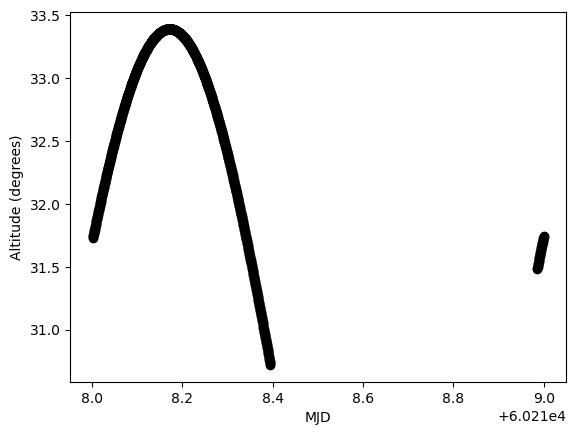

In [23]:
# Look at where the observations were pointed
plt.plot(observations['mjd'], np.degrees(observations['alt']), 'ko')
plt.xlabel('MJD')
plt.ylabel('Altitude (degrees)')


Text(0, 0.5, 'sky brightness (mag/sq acrsec)')

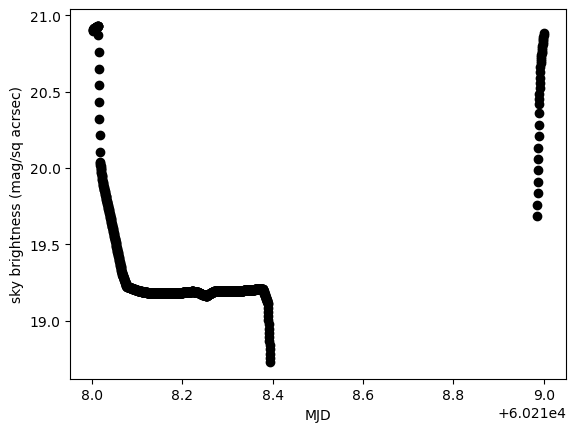

In [24]:
# Check the sky brightness of the observations
plt.plot(observations['mjd'], observations['skybrightness'], 'ko')
plt.xlabel('MJD')
plt.ylabel('sky brightness (mag/sq acrsec)')


Text(0, 0.5, 'Moon Altitude (degrees)')

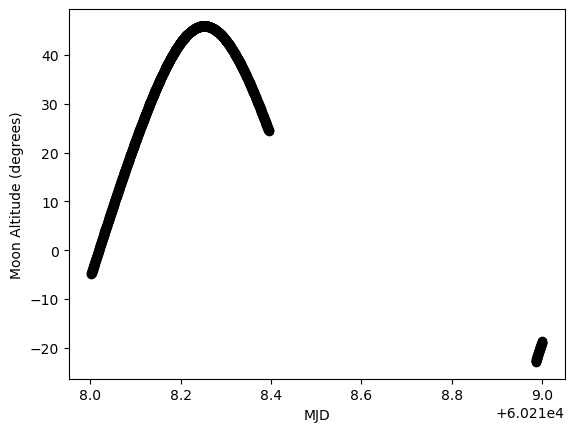

In [25]:
# Wait, magnitudes are backwards, why did the sky get brighter during the night?
# Check what the moon was doing
plt.plot(observations['mjd'], np.degrees(observations['moonAlt']), 'ko')
plt.xlabel('MJD')
plt.ylabel('Moon Altitude (degrees)')


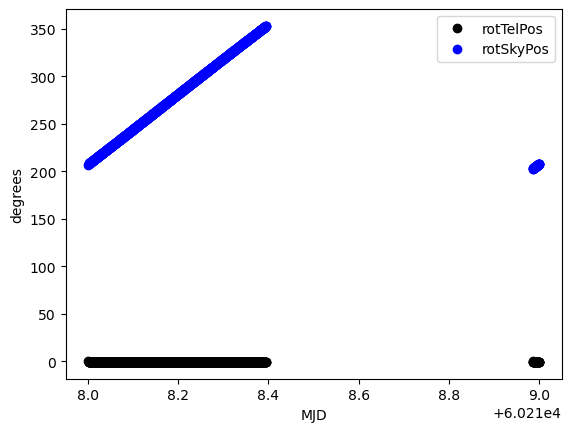

In [26]:
# How the camera rotator behaved. 
plt.plot(observations['mjd'], np.degrees(observations['rotTelPos']), 'ko', label='rotTelPos')
plt.plot(observations['mjd'], np.degrees(observations['rotSkyPos']), 'bo', label='rotSkyPos')
plt.ylabel('degrees')
plt.xlabel('MJD')
plt.legend()

OK, rotTelPos is exactly zero, so it was using that value.

Note, if you have `sim_runner` output the results to a sqlite file, it does some schema name converting, and does  radians to degrees conversions. That whole schema is in the docs here: https://rubin-sim.lsst.io/rs_scheduler/output_schema.html

In [27]:
# OK, so a detailer is an object that takes a list of observations and the current conditions, 
# and returns a list of observations. So you might do something like, "repeat the list until expected sunrise",
# or, "repeat in 3 different bands". 
# Let's make a detailer to adjust the rotation angle

class PerpRotDetailer(BaseDetailer):
    """Make it so North-South is always aligned along rows or columns
    """
    def __init__(self, telescope="rubin"):
        self.survey_features = {}
        self.rc = rotation_converter(telescope=telescope)
    
    def __call__(self, observation_list, conditions):
        possible_rot_sky = np.array(np.radians([0.,90.,270., 360.]))
        # Note, this is a stupid loop. It's fine to 
        # concatenate the obs_list into an array, do array operations,
        # then convert it back to a list at the end.
        for obs in observation_list:
            # Set rotTelPos to NaN, forcing observatory to use rotSkyPos value
            obs['rotTelPos'] = np.nan
            alt, az = _approx_ra_dec2_alt_az(obs["RA"],obs["dec"],
                                          conditions.site.latitude_rad,
                                          conditions.site.longitude_rad,
                                          conditions.mjd)
            obs_pa = _approx_altaz2pa(alt, az, conditions.site.latitude_rad)
            possible_rtp = self.rc._rottelpos2rotskypos(possible_rot_sky, obs_pa)
            in_range = np.min(np.where((possible_rtp >= 3.*np.pi/2) | (possible_rtp <= np.pi/2))[0])
            obs['rotSkyPos'] = possible_rot_sky[in_range]
            obs['rotSkyPos_desired'] = possible_rot_sky[in_range]
            obs['rotTelPos_backup'] = np.radians(-0.2) 
        return observation_list

In [28]:
# reset our model observatory
mo = ModelObservatory(nside=nside, mjd_start=mjd_start, downtimes="ideal")


In [29]:
# Make our survey object, this time with our detailer
scp_survey = ScpSurvey([], detailers=[PerpRotDetailer()])

scheduler = CoreScheduler([scp_survey], nside=nside)
mo, scheduler, observations = sim_runner(mo, scheduler, sim_duration=1.0,
                                                 verbose=True)

progress = 98.37%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 958 observations
ran in 0 min = 0.0 hours


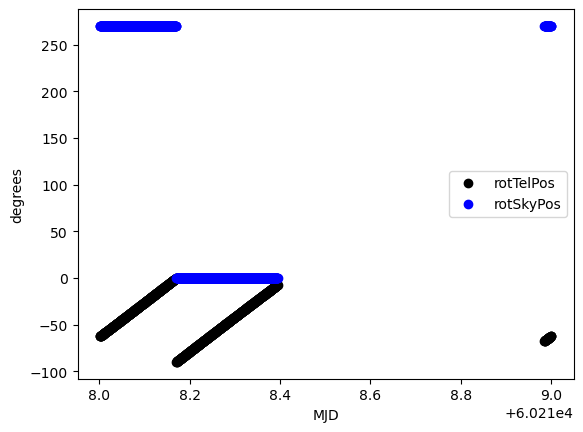

In [30]:
# How the camera rotator behaved. 
plt.plot(observations['mjd'], np.degrees(observations['rotTelPos']), 'ko', label='rotTelPos')
plt.plot(observations['mjd'], np.degrees(observations['rotSkyPos']), 'bo', label='rotSkyPos')
plt.ylabel('degrees')
plt.xlabel('MJD')
plt.legend()

In [31]:
# So this slight offset is probably the way the observatory model is dealing with things.
np.degrees(observations['rotSkyPos'])[0:10]

ObservationArray([270., 270., 270., 270., 270., 270., 270., 270., 270.,
                  270.])

In [32]:
np.degrees(observations['rotTelPos'])[0:10]

ObservationArray([-62.75284811, -62.59695309, -62.44104483, -62.28512334,
                  -62.12918862, -61.97324069, -61.81727955, -61.66130523,
                  -61.50531772, -61.34931703])

In [33]:
# One can daisy-chain as many detailers as you like in a row. Note they are applied in order, and 
# do not always commute.